In [1]:
import pandas as pd
import numpy as np
import statsmodels as sm
import sklearn as skl
import seaborn as sns
import scipy as sc
import matplotlib.pyplot as plt
import yfinance as yf
import warnings
import joblib

from plotly import graph_objs as go
from datetime import date,timedelta,datetime
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.stats import norm, skew
from scipy.special import boxcox1p
from sklearn.metrics import mean_squared_error, r2_score #model evaluation
from sklearn.linear_model import LinearRegression , Ridge, Lasso, ElasticNet
#import xgboost as xg
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import r2_score
from statsmodels.formula.api import ols
from statsmodels.formula.api import quantreg
from statsmodels.stats.diagnostic import het_white
from statsmodels.stats.diagnostic import het_breuschpagan
from sklearn.linear_model import Ridge
from sklearn import svm
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from IPython.display import Image
warnings.filterwarnings('ignore')

In [2]:
df =  yf.Ticker("^GSPC").history(start='2016-01-01', end='2024-07-12')
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2016-01-04 00:00:00-05:00,2038.199951,2038.199951,1989.680054,2012.660034,4304880000,0.0,0.0
2016-01-05 00:00:00-05:00,2013.780029,2021.939941,2004.170044,2016.709961,3706620000,0.0,0.0
2016-01-06 00:00:00-05:00,2011.709961,2011.709961,1979.050049,1990.260010,4336660000,0.0,0.0
2016-01-07 00:00:00-05:00,1985.319946,1985.319946,1938.829956,1943.089966,5076590000,0.0,0.0
2016-01-08 00:00:00-05:00,1945.969971,1960.400024,1918.459961,1922.030029,4664940000,0.0,0.0


In [3]:
df['Yesterday_High']=df['High'].shift()
df['Yesterday_Low']=df['Low'].shift()
df['Yesterday_Volume']=df['Volume'].shift()
df['Yesterday_Close']=df['Close'].shift()
df.drop(index=df.index[0], axis=0, inplace=True)
df.drop(['Open','High', 'Low','Dividends','Stock Splits','Volume'], axis=1,inplace=True)

In [4]:
df.head()

,Close,Yesterday_High,Yesterday_Low,Yesterday_Volume,Yesterday_Close
Date,,,,,
2016-01-05 00:00:00-05:00,2016.709961,2038.199951,1989.680054,4.304880e+09,2012.660034
2016-01-06 00:00:00-05:00,1990.260010,2021.939941,2004.170044,3.706620e+09,2016.709961
2016-01-07 00:00:00-05:00,1943.089966,2011.709961,1979.050049,4.336660e+09,1990.260010
2016-01-08 00:00:00-05:00,1922.030029,1985.319946,1938.829956,5.076590e+09,1943.089966
2016-01-11 00:00:00-05:00,1923.670044,1960.400024,1918.459961,4.664940e+09,1922.030029


In [5]:
def Feature_Generation(df):
    # adding the SMA features
    df['SMA_3']=df['Yesterday_Close'].rolling(window=3,min_periods=1).mean()
    df['SMA_7']=df['Yesterday_Close'].rolling(window=7,min_periods=1).mean()
    df['SMA_14']=df['Yesterday_Close'].rolling(window=14,min_periods=1).mean()
    df['SMA_50']=df['Yesterday_Close'].rolling(window=50,min_periods=1).mean()
    df['SMA_150']=df['Yesterday_Close'].rolling(window=150,min_periods=1).mean()
    # adding the EMA features
    df['EMA_3']=df['Yesterday_Close'].ewm(span=3, adjust=False,min_periods=1).mean()
    df['EMA_7']=df['Yesterday_Close'].ewm(span=7, adjust=False,min_periods=1).mean()
    df['EMA_14']=df['Yesterday_Close'].ewm(span=14, adjust=False,min_periods=1).mean()
    df['EMA_50']=df['Yesterday_Close'].ewm(span=50, adjust=False,min_periods=1).mean()
    df['EMA_150']=df['Yesterday_Close'].ewm(span=150, adjust=False,min_periods=1).mean()
    #Bollinger Bands
    TP=(df['Yesterday_High']+df['Yesterday_Low'])/2
    df['BOLM']=TP.rolling(window=14).mean()
    std_tp=TP.rolling(window=14).std()
    df['BOLU']=df['BOLM']+2*std_tp
    df['BOLD']=df['BOLM']-2*std_tp
    
    #CCI
    ma =TP.rolling(window=20).mean()
    df['CCI'] = (TP - ma) / (0.015 * std_tp) 
    
    #William’s %R
    high_h= df['Yesterday_High'].rolling(window=14).max() 
    low_l= df['Yesterday_Low'].rolling(window=14).min()
    df['wr'] = -100 * (( high_h - df['Yesterday_Low']) / (high_h - low_l))
    
    #Stochastic %K
    
    # Uses the min/max values to calculate the %k (as a percentage)
    df['%K'] = (df['Yesterday_Low'] - low_l) * 100 / (high_h -low_l)
    # Uses the %k to calculates a SMA over the past 3 values of %k
    df['%D'] = df['%K'].rolling(window=14).mean()
    
    #MFI
    money_flow = TP * df['Yesterday_Volume']
    mf_sign = np.where(TP>TP.shift(1), 1, -1)
    signed_mf =money_flow * mf_sign
    mf_avg_pos = signed_mf.rolling(window=14).apply(lambda x: ((x>0)*x).sum(), raw=True)
    mf_avg_neg= signed_mf.rolling(window=14).apply(lambda x: ((x<0)*x).sum(), raw=True)
    df['MFI']=100 - (100 / (1 + (mf_avg_pos / abs(mf_avg_neg))))
    
    #ATR
    high_low = df['Yesterday_High'] - df['Yesterday_Low']
    high_cp = np.abs(df['Yesterday_High'] - df['Yesterday_Close'])
    low_cp = np.abs(df['Yesterday_Low'] - df['Yesterday_Close'])
    
    true_range = np.max(pd.concat([high_low, high_cp, low_cp], axis=1), axis=1)
    df['ATR'] = true_range.rolling(14).mean()

    df=df.fillna(0, inplace=True)
    
    return df

In [6]:
#Feature_Generation(df)
data=Feature_Generation(df)
data=df

In [7]:
data.tail()

,Close,Yesterday_High,Yesterday_Low,Yesterday_Volume,Yesterday_Close,SMA_3,SMA_7,SMA_14,SMA_50,SMA_150,...,EMA_150,BOLM,BOLU,BOLD,CCI,wr,%K,%D,MFI,ATR
Date,,,,,,,,,,,,,,,,,,,,,
2024-07-05 00:00:00-04:00,5567.189941,5539.270020,5507.419922,2.179470e+09,5537.020020,5507.039876,5487.381348,5473.066406,5300.523389,5059.852601,...,5070.988082,5468.189628,5520.867306,5415.511949,222.211683,-23.289002,76.710998,74.574371,55.441241,38.860770
2024-07-08 00:00:00-04:00,5572.850098,5570.330078,5531.629883,3.253080e+09,5567.189941,5537.739909,5501.365653,5482.598528,5310.456191,5066.601266,...,5077.560292,5477.386771,5539.590795,5415.182747,223.293134,-23.232187,76.767813,74.165363,61.642960,38.809326
2024-07-09 00:00:00-04:00,5576.979980,5583.109863,5562.509766,3.185670e+09,5572.850098,5559.020020,5514.929967,5492.687814,5320.480596,5073.416400,...,5084.120422,5488.439610,5559.588705,5417.290515,215.144603,-12.660625,87.339375,74.476803,67.741161,38.235038
2024-07-10 00:00:00-04:00,5633.910156,5590.750000,5574.569824,3.232920e+09,5576.979980,5572.340007,5528.374233,5500.098528,5331.051797,5080.144268,...,5090.648363,5497.597464,5581.722225,5413.472704,179.388222,-11.219076,88.780924,75.314244,67.659470,34.526472
2024-07-11 00:00:00-04:00,5584.540039,5635.390137,5586.439941,3.336100e+09,5633.910156,5594.580078,5553.149972,5510.589983,5341.730801,5087.072803,...,5097.843883,5506.887835,5609.697900,5404.077769,166.422823,-25.918725,74.081275,73.918693,67.582838,36.661482


In [8]:

#insert date column
data.insert(loc=0, column='Date', value=data.index.get_level_values(0))
#sort the rows by date
data.sort_index(ascending=True, axis=0, inplace=True)
data.reset_index(inplace=True, drop=True)

In [9]:
data.shape

(2143, 25)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2143 entries, 0 to 2142
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype                           
---  ------            --------------  -----                           
 0   Date              2143 non-null   datetime64[ns, America/New_York]
 1   Close             2143 non-null   float64                         
 2   Yesterday_High    2143 non-null   float64                         
 3   Yesterday_Low     2143 non-null   float64                         
 4   Yesterday_Volume  2143 non-null   float64                         
 5   Yesterday_Close   2143 non-null   float64                         
 6   SMA_3             2143 non-null   float64                         
 7   SMA_7             2143 non-null   float64                         
 8   SMA_14            2143 non-null   float64                         
 9   SMA_50            2143 non-null   float64                         
 10  SMA_150           2143 n

In [11]:
data.describe()

,Close,Yesterday_High,Yesterday_Low,Yesterday_Volume,Yesterday_Close,SMA_3,SMA_7,SMA_14,SMA_50,SMA_150,...,EMA_150,BOLM,BOLU,BOLD,CCI,wr,%K,%D,MFI,ATR
count,2143.000000,2143.000000,2143.000000,2.143000e+03,2143.000000,2143.000000,2143.000000,2143.000000,2143.000000,2143.000000,...,2143.000000,2143.000000,2143.000000,2143.000000,2143.000000,2143.000000,2143.000000,2143.000000,2143.000000,2143.000000
mean,3375.750130,3391.534910,3353.973410,4.054634e+09,3374.083364,3372.402730,3369.070711,3363.292149,3334.262730,3260.247014,...,3266.828956,3350.036789,3436.998738,3263.074841,44.072975,-45.919762,53.473612,53.120045,55.067989,37.329218
std,927.549208,931.396639,921.376231,9.817998e+08,926.787198,925.656336,923.687767,920.582965,906.854679,876.342781,...,872.605525,950.546782,977.916403,926.874586,99.875842,31.039838,31.113599,22.423270,15.054933,23.072698
min,1829.079956,1847.000000,1810.099976,1.296530e+09,1829.079956,1844.383301,1860.999983,1886.709987,1905.024992,1905.024992,...,1971.132116,0.000000,0.000000,0.000000,-219.673830,-100.000000,0.000000,0.000000,0.000000,0.000000
25%,2635.814941,2651.289917,2608.040039,3.448925e+09,2635.114990,2634.856689,2634.275722,2632.591797,2632.074199,2590.296746,...,2608.242179,2635.105543,2704.808171,2555.880905,-35.077959,-71.245854,27.176323,35.426731,44.868248,18.106428
50%,3132.520020,3150.300049,3118.770020,3.845600e+09,3131.290039,3133.099935,3125.397112,3119.299264,3060.474385,3026.038659,...,2999.499335,3118.119646,3246.139995,3025.821396,71.483363,-37.469543,62.099750,58.287220,56.185612,34.106480
75%,4178.289795,4196.824951,4151.095215,4.414230e+09,4176.149902,4178.726725,4172.885010,4171.164690,4133.863508,4098.561274,...,4116.659050,4169.512137,4259.995991,4077.280790,119.408880,-18.785978,80.921086,71.740103,64.975231,49.644645
max,5633.910156,5635.390137,5586.439941,9.976520e+09,5633.910156,5594.580078,5553.149972,5510.589983,5341.730801,5087.072803,...,5097.843883,5506.887835,5609.697900,5417.290515,287.674995,0.000000,95.624766,89.158910,100.000000,154.172834


In [12]:
data.isnull().sum()

Date                0
Close               0
Yesterday_High      0
Yesterday_Low       0
Yesterday_Volume    0
Yesterday_Close     0
SMA_3               0
SMA_7               0
SMA_14              0
SMA_50              0
SMA_150             0
EMA_3               0
EMA_7               0
EMA_14              0
EMA_50              0
EMA_150             0
BOLM                0
BOLU                0
BOLD                0
CCI                 0
wr                  0
%K                  0
%D                  0
MFI                 0
ATR                 0
dtype: int64

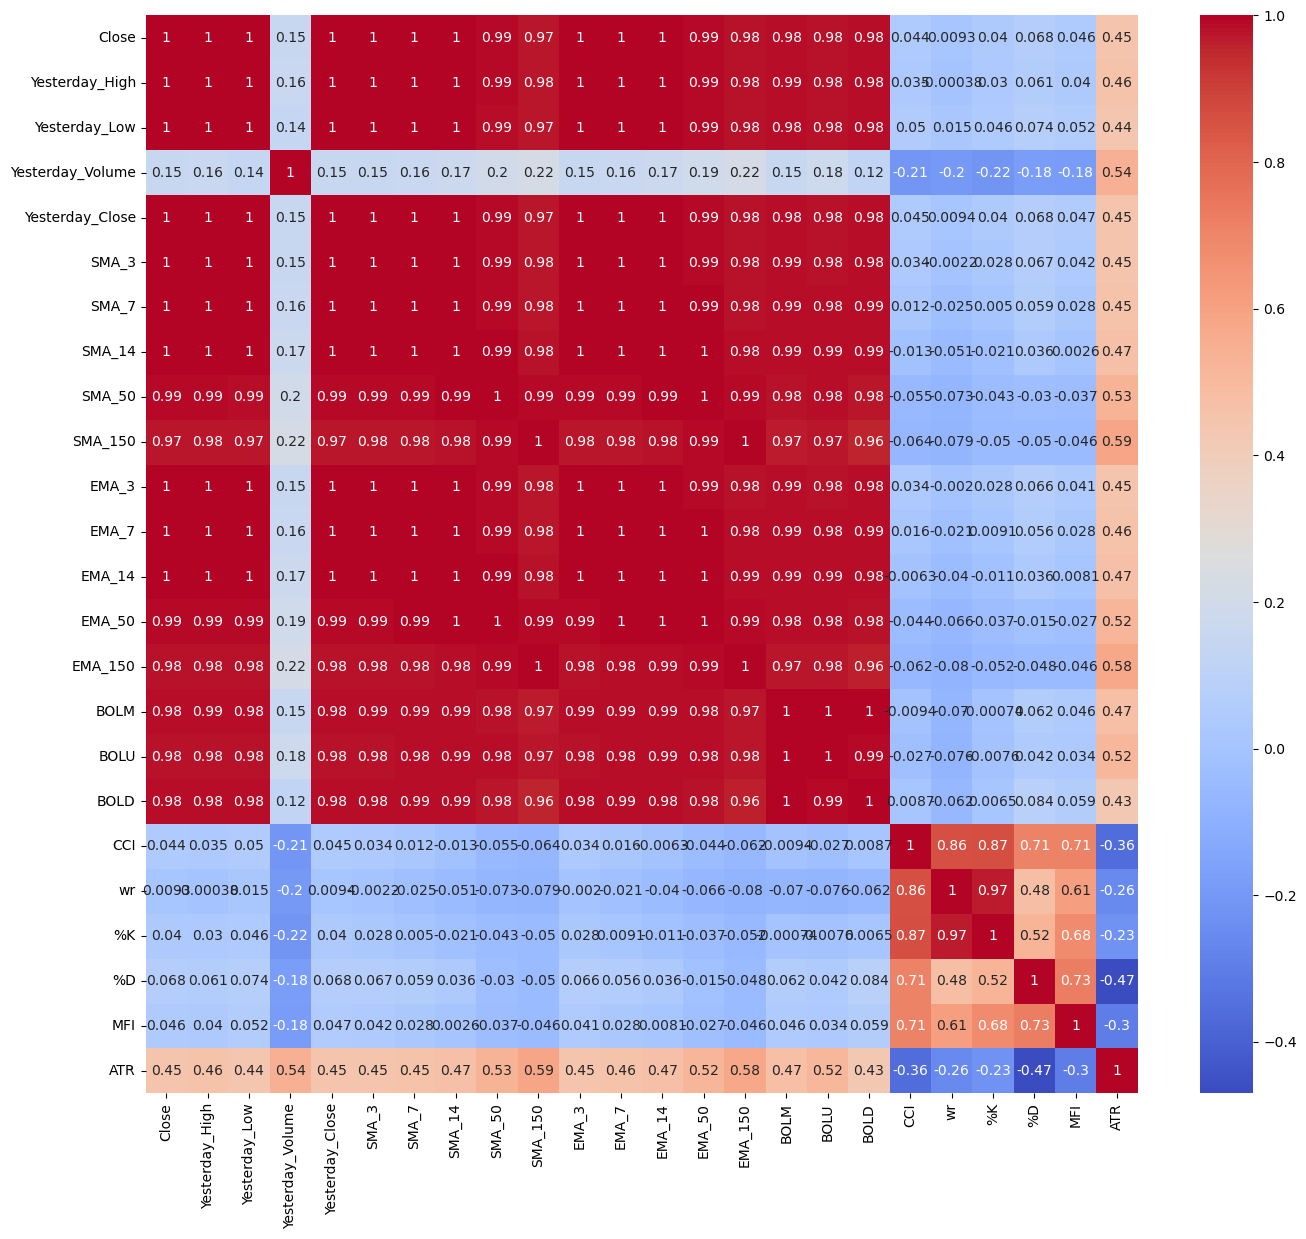

In [13]:
plt.figure(figsize=(16,14))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.show()

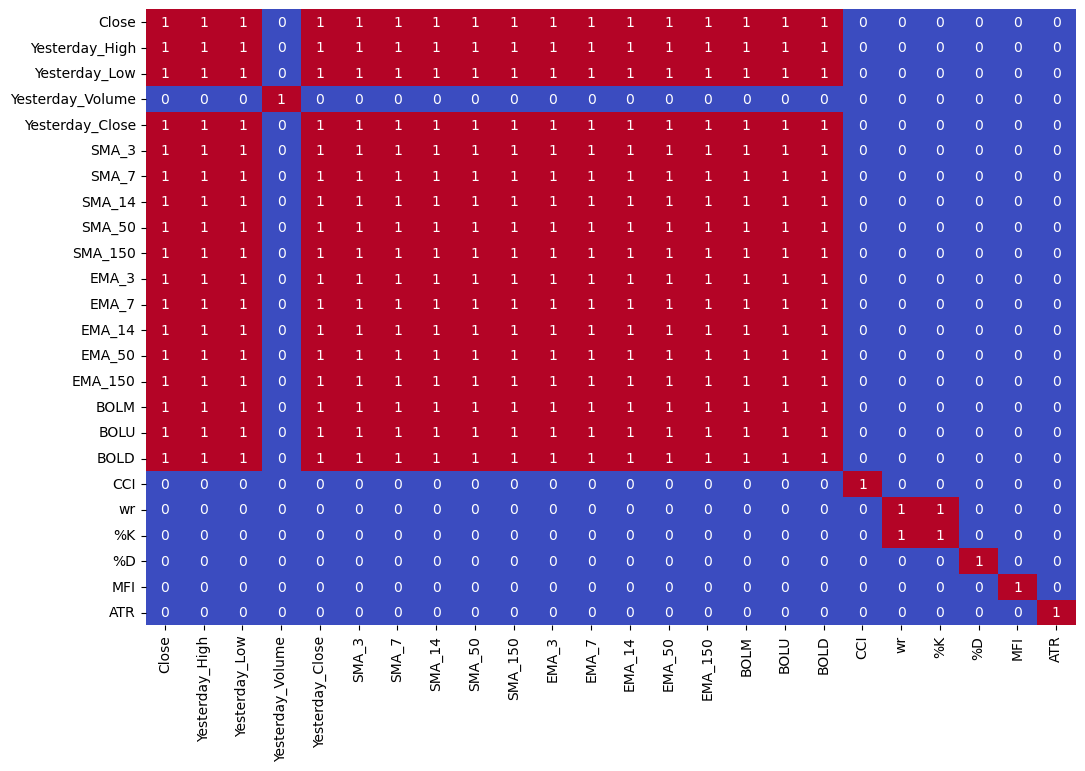

In [14]:
plt.figure(figsize=(12,8))
sns.heatmap(data.corr()>=0.95, annot=True, cmap='coolwarm',cbar=False)
plt.show()

In [15]:
data.corr()['Close'].sort_values(ascending=False)

Close               1.000000
Yesterday_Close     0.999161
Yesterday_Low       0.998994
EMA_3               0.998971
Yesterday_High      0.998943
SMA_3               0.998812
EMA_7               0.998310
SMA_7               0.997910
EMA_14              0.997110
SMA_14              0.996253
EMA_50              0.991939
SMA_50              0.989009
BOLM                0.984065
BOLD                0.983294
BOLU                0.981075
EMA_150             0.979639
SMA_150             0.973784
ATR                 0.448671
Yesterday_Volume    0.151562
%D                  0.067662
MFI                 0.046355
CCI                 0.044141
%K                  0.039904
wr                  0.009285
Name: Close, dtype: float64

In [16]:
def probplot(data,value):
    plt.figure(figsize=(7,4))
    sc.stats.probplot(value,dist="norm",plot=plt)
    plt.title("QQ test for normality distribution close")
    plt.legend(['Actual','Theoretical'])
    plt.show()

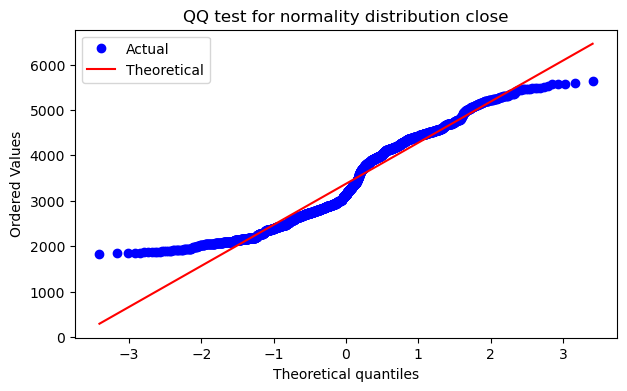

In [17]:
probplot(data,data['Close'])

In [18]:
negative_features = []
for column in data.columns.drop('Date'):
    # Check if any value in the column is negative and skewed
    if (data[column] < 0).any() and skew(data[column]>60):
        negative_features.append(column)
for feature in negative_features:
    feature_values = data[feature]
    # Add a constant to make all values positive
    feature_positive = feature_values - np.min(feature_values) +1 
    # Apply boxcox transformation
    transformed_feature = boxcox1p(feature_positive, 0.15) 
    # Save the transformed feature back into the original DataFrame
    data[feature] = transformed_feature

#positive features:
negative_features.append('Date')
numeric_feats =data.columns.drop(negative_features)
count=0
for feat in numeric_feats:
    if skew(data[feat]>60):
        data[feat] = boxcox1p(data[feat], 0.15) 
        count=count+1
print(f"There are {count+len(negative_features)-1} skewed features")

There are 24 skewed features


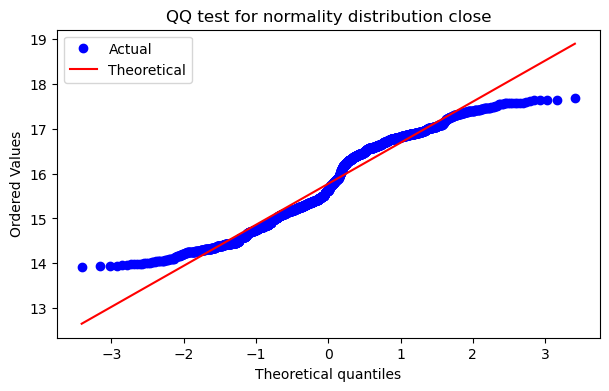

In [19]:
probplot(data,data['Close'])

In [20]:
#model_evaluation
def MSE(y_true, y_pred):
    return np.mean(np.square(y_true - y_pred))
def RMSE(y_true, y_pred):
    return np.sqrt(np.mean(np.square(y_true - y_pred)))
def MAPE(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
def MBE (y_true, y_pred):
    return np.mean(y_true - y_pred)
def MAE(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))
def R2(y_true, y_pred):
    return r2_score(y_true, y_pred)
def model_evaluation(y_true, y_pred):
    return {'MSE': MSE(y_true, y_pred)[0], 'RMSE': RMSE(y_true, y_pred)[0], 'MAPE':MAPE(y_true, y_pred)[0],'MBE':MBE(y_true, y_pred)[0],
            "MAE":MAE(y_true, y_pred)[0],'R2': R2(y_true, y_pred)}

def data_prep(df):
    df=df.set_index('Date')
    x = df.drop(columns=['Close'], axis=1)
    y = pd.DataFrame(df['Close'])
    # Split the data into training and test sets
    X_train=x[:'2023-07-01']
    X_test=x['2023-07-01':]
    y_train=y[:'2023-07-01']
    y_test =y['2023-07-01':]
    
    #scalling
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    X_train=pd.DataFrame(X_train,columns=x.columns)
    X_test=pd.DataFrame(X_test,columns=x.columns)
    
    
    # Save the scalers
    joblib.dump(scaler, 'scaler_leniar_reg.pkl')
    
    return X_train, X_test, y_train, y_test

#prediction vs actual plot
def Pred_Act_plot(predictions,model_name):
    print("model_evaluation:")
    print(model_evaluation(y_test,predictions))
    plt.plot(y_test['Close'].values,'r-',label='Actual')
    plt.plot(predictions,'b--',label='Predictions')
    plt.title(f"{model_name}-Predictions vs Actual Prices")
    plt.ylabel('Price')
    plt.legend()
    plt.show()

In [21]:
x_train, x_test, y_train, y_test = data_prep(data)

In [22]:
print("The size of the training set is: ", x_train.shape)
print("The size of the test set is: ", x_test.shape)
print("The size of the y training set is: ", y_train.shape)
print("The size of the y test set is: ", y_test.shape)

The size of the training set is:  (1885, 23)
The size of the test set is:  (258, 23)
The size of the y training set is:  (1885, 1)
The size of the y test set is:  (258, 1)


In [23]:
df=pd.DataFrame(columns=['Model','MSE','RMSE','MAPE','MBE','MAE','R2'])

model_evaluation:
{'MSE': 0.0007020867705117979, 'RMSE': 0.02649692001934938, 'MAPE': 0.12309829882612183, 'MBE': 0.00353918565222119, 'MAE': 0.021010471302558727, 'R2': 0.9915643032328351}


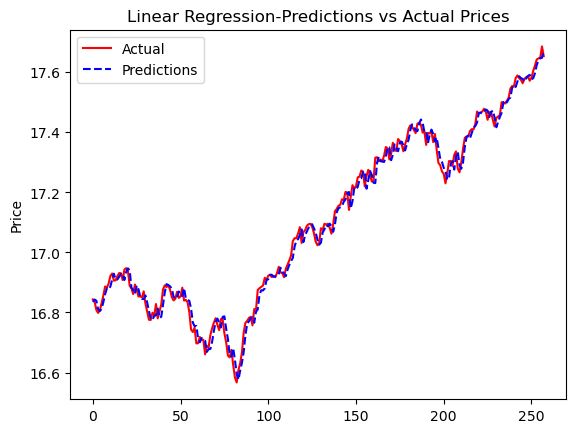

In [24]:
reg = LinearRegression()
reg.fit(x_train, y_train)
predictions = reg.predict(x_test)

Pred_Act_plot(predictions,'Linear Regression')
reg_evaluation=list(model_evaluation(y_test,predictions).values())
reg_evaluation.insert(0,'Linear Regression')
df.loc[len(df)]=reg_evaluation

In [25]:
from scipy.special import boxcox1p
from scipy.special import inv_boxcox1p
lmbda = 0.15


In [26]:
index = y_test.index
Real = inv_boxcox1p(y_test['Close'], lmbda)
Predict_df=pd.DataFrame(predictions)
prediction = inv_boxcox1p(Predict_df[0], lmbda)


In [27]:
df_compare = pd.DataFrame({
    'Real': Real.values,'Predict':prediction.values,'Delta':abs(prediction.values-Real.values)
},index=index)

In [28]:
df_compare

,Real,Predict,Delta
Date,,,
2023-07-03 00:00:00-04:00,4455.589844,4444.927594,10.662250
2023-07-05 00:00:00-04:00,4446.819824,4454.809429,7.989605
2023-07-06 00:00:00-04:00,4411.589844,4449.906360,38.316516
2023-07-07 00:00:00-04:00,4398.950195,4414.721395,15.771200
2023-07-10 00:00:00-04:00,4409.529785,4406.608780,2.921005
...,...,...,...
2024-07-05 00:00:00-04:00,5567.189941,5538.783800,28.406141
2024-07-08 00:00:00-04:00,5572.850098,5563.613299,9.236798
2024-07-09 00:00:00-04:00,5576.979980,5574.167676,2.812304


In [29]:
df_compare.describe()


,Real,Predict,Delta
count,258.000000,258.000000,258.000000
mean,4812.755426,4807.820367,28.090257
std,391.431966,388.858382,21.394584
min,4117.370117,4128.079321,0.009099
25%,4467.989990,4468.347224,10.608265
50%,4767.175049,4758.368956,25.336868
75%,5155.639893,5149.916875,40.332559
max,5633.910156,5616.256437,118.796028


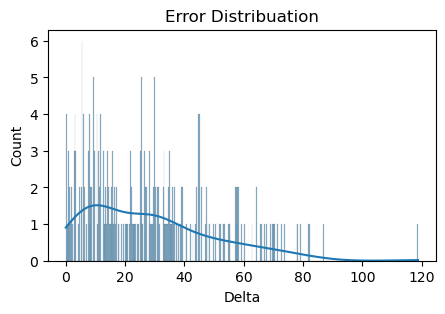

In [30]:
plt.figure(figsize=(5,3))
plt.title("Error Distribuation")
sns.histplot(data=df_compare, x="Delta", bins=400,kde=True)
plt.show()